In [1]:
from matplotlib import pyplot as plt
import numpy as np
import classifier_utils
from classifier_utils import cnn_model, preprocess_img, get_class
%matplotlib inline
import glob
import os
from skimage import io
from skimage import transform
import keras
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.models import Sequential, Model
import vgg16
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot #used for printing test
from keras import backend as K

Using TensorFlow backend.


# Loading CIFAR10 dataset

* -x_train: training set samples
* -y_train: training set labels

+ -x_test: test set samples
+ -y_test: test set labels

In [2]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
#set size of sample and number of classes
IMG_SIZE = 64 
NUM_CLASSES = 10

In [4]:
x_train_vgg = np.zeros(((len(x_train)),IMG_SIZE,IMG_SIZE,3))

for i in range(len(x_train)):
    x_train_vgg[i] = transform.resize(x_train[i], (IMG_SIZE, IMG_SIZE), order=0, preserve_range=True) #need to preserve range for Float32

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
x_test_vgg = np.zeros((10000,IMG_SIZE,IMG_SIZE,3))

for i in range(10000):
    x_test_vgg[i] = transform.resize(x_test[i], (IMG_SIZE, IMG_SIZE), order=0, preserve_range=True)

/usr/local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


### Training set vertical rotation

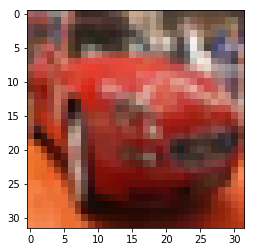

In [6]:
single_image = x_train[5:6]
plt.imshow(single_image[0])         

In [7]:
x_train_rot = x_train[:,:,::-1,:] #rotate samples

In [11]:
print (len(x_train_rot))

50000


In [8]:
x_train_vgg_rot = np.zeros(((len(x_train_rot)),IMG_SIZE,IMG_SIZE,3))

for i in range(len(x_train_rot)):
    x_train_vgg_rot[i] = transform.resize(x_train_rot[i], (IMG_SIZE, IMG_SIZE), order=0, preserve_range=True) #need to preserve range for Float32

MemoryError: 

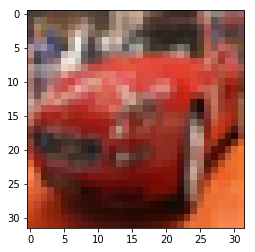

In [5]:
single_image = x_train_rot[5:6]
plt.imshow(single_image[0])         

###### Concatenation!

In [6]:
x_train = np.concatenate((x_train_vgg, x_train_vgg_rot), axis=0)
y_train = np.concatenate((y_train, y_train), axis=0)

In [7]:
print (x_train.shape)
print (y_train[50005])

(100000, 32, 32, 3)
[1]


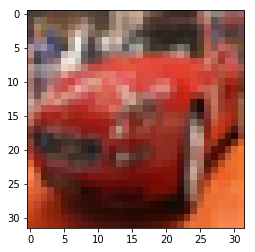

In [8]:
single_image = x_train[50005:50006]
plt.imshow(single_image[0]) 

### Switch training set and test set RGB to BGR order (BGR is expected as a default Vgg16 input).

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [10]:
x_train = x_train[:, :, :, ::-1]  

# Subtract ImageNet mean pixel 
x_train[:, :, :, 0] -= 103
x_train[:, :, :, 1] -= 116
x_train[:, :, :, 2] -= 123

In [11]:
x_test = x_test[:, :, :, ::-1]  

# Subtract ImageNet mean pixel 
x_test[:, :, :, 0] -= 103
x_test[:, :, :, 1] -= 116
x_test[:, :, :, 2] -= 123

### Image resizing. 
Vgg16 takes minimum size of 48x48!

Pay attention on example below:
```python
x_train_vgg[i] = transform.resize(x_train[i], (64, 64), order=0, preserve_range=True)
```
1. transform.resize changes values by default into range from -1 to 1.
2. To avoid mixing data types need to use: 
```python 
preserve_range=True
```

In [12]:
print (len(x_train))

100000


In [13]:
#x_train = x_train[:55000]

### Validation set
Validation set is used during training. 

#### To sum up
###### Training set: 
Used to adjust the weights on the neural network.

###### Validation set: 
Used to minimize overfitting by proper verifyication. 
###### Overfitting: 
If the accuracy over the training data set increases, but the accuracy over the validation data set stays the same or decreases, then you're overfitting your neural network and you should stop training.

###### Testing set: 
Used only for final testing to confirm the actual predictive power of the current network.

In [ ]:
size_of_dataset = (len(x_train)) #in case of CIFAR it is 50000 (Augmented=100000)

mask = np.random.rand(size_of_dataset) < 0.8  #array of boolean variables

training_set = x_train_vgg[mask]
training_labels = y_train[mask]

validation_set = x_train_vgg[~mask]
validation_labels = y_train[~mask]

### Sample printing

In [ ]:
single_image = training_set[25:26]
plt.imshow(single_image[0])         

# Setting up model
Current example uses Vgg16 model. In case of this project there are only 10 categories so model need to be set with some changes on last layer. 
Last layer is removed with: 

```python 
include_top=False
```
then all layers are set to trainable and new Dense layer with 10 categories is added. 

In [ ]:
model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMG_SIZE,IMG_SIZE,3), pooling=max)

### Setting all layers to trainable.
In this scenario all layers were set to trainable. 

In [ ]:
for layer in model.layers: layer.trainable=True

In [ ]:
model.summary()

### Alternative way to add last layer and activation 

In [ ]:
#model.add(Dense(NUM_CLASSES, activation='softmax')) .add doesn't work for VGG16

last = model.output

x = Flatten()(last)
preds = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(model.input, preds)

In [ ]:
model.summary()

# Training
#### Set optimizer for tweaks (leraning rate lr=0.001 to lr=0.0001) !Unquote Adam!

In [ ]:
Adam=keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [ ]:
model.compile(optimizer=Adam,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#NO validation
model.fit(x_train_vgg, y_train, batch_size=128, epochs=3) 
#with validation
#model.fit(training_set, training_labels, batch_size=128, epochs=1, validation_data=(validation_set, validation_labels))

# Evaluation

###### Test set need to be in same dimension as a training set

In [ ]:
print (x_test_vgg.shape)

In [ ]:
model.evaluate(x_test_vgg, y_test) #x_test_vgg is resized test set (64x64)